# SDSS Activity: Modeling H-R Diagrams

Today we will apply numerical models of stellar evolution to determine the distance, metallicity, and age of globular clusters observed in the SDSS. You may find it useful to refer to the project background and helpful hints posted here:
http://voyages.sdss.org/hr-diagrams/

In [1]:
# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SkyServer as SkyServer # look up objects and generate images
print('SciServer libraries imported')

SciServer libraries imported


In [2]:
# Import some other needed libraries
import pandas
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
print('Other libraries imported')

Other libraries imported


In [3]:
# Apply some settings

# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Settings applied


## Choosing a star cluster

The first, and very important, step is selecting a cluster with good photometric data. If you already have a favorite cluster, type it into the “name” box in [Navigate](http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx) and click “Resolve” to see if it’s in the SDSS database. If not, you can look at [this catalog](http://www.galaxyzooforum.org/index.php?topic=278836.0) of open and globular clusters that have already been found with SDSS data and choose one that you like. When you’ve found an object, type its name into Navigate as just explained, and it will likely appear automatically. Some of the clusters aren’t listed in the SDSS index, however; if that’s the case, each object’s RA and Dec can be found by clicking on its image in the catalog. You can then type the values into Navigate by hand.

While selecting a cluster, don’t be afraid to look closely at several in order to compare your options and find the one best suited to your needs—not every cluster in the database will produce a good HR diagram. Ask yourself:

- What kinds of data do you need to build a Hertzsprung-Russell diagram?
- How many data points (stars) will be necessary to see a clear and distinct trend?
- Why do some clusters have better photometry than others? How will that affect your plot?
- What are the advantages/disadvantages to changing the radius of your search?

## Fetch the data for the star cluster of choice

You can find a resource to get you started with your own SQL searches [here](http://voyages.sdss.org/sql-for-cmds/).

To start your query, think about exactly which data you’re looking for and what criteria you’ll use to select it. You can explore the [Schema Browser](http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx) to better understand the all of the information at your disposal in the SDSS database.  While answering the questions below you will likely want to review the data model for the “PhotoObj” schema, which provides from the best photometric data available. In general, it may be a good idea to request more options than you think you’ll need, in case you change your mind later.

Several magnitude-fitting models are available in PhotoObj: psfMag, fiberMag, petroMag, deVMag, expMag, modelMag, cModelMag, and dered.   You can find them defined [here](http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoPrimary+V).
- How do they differ? 
- Which is best suited to the plot you’ll be making, where brightness and color are the two important variables?


In [4]:
## Create a query to fetch stars for one of the following globular clusters
# Pal 3: RA = 151.3801, Dec = +0.072
# Pal 5: RA = 229.0128, Dec = -0.1082 

# Enter the coordinates of your star cluster (to be used to construct the query)
cluster_name = 'Palomar 5'
cluster_ra = 229.0128  # RA of the center of the cluster (in decimal degrees)
cluster_dec = -0.182   # Dec of the center of the cluster (in decimal degrees)
cluster_radius = 4.0   # Radius of the cluster, in arcminutes
cluster_distance = 23000 # approximate distance to your cluster, in units of parsecs

query = 'SELECT p.objid, p.psfMag_u AS u, p.psfMagErr_u as u_err, p.psfMag_g AS g, p.psfMagErr_g as g_err, '
#query = 'SELECT p.objid, p.dered_u AS u, p.psfMagErr_u as u_err, p.dered_g AS g, p.psfMagErr_g as g_err, ' # de-reddened mags
query += 'p.dered_r AS r, p.psfMagErr_r as r_err, p.dered_i AS i, p.psfMagErr_i as i_err, '
query += 'p.dered_z AS z, p.psfMagErr_z as z_err '
query += 'FROM photoObj p '
query += 'JOIN dbo.fGetNearbyObjEq(' + str(cluster_ra) + ', ' + str(cluster_dec) + ', ' + str(cluster_radius) + ') n '
query += 'ON p.objid = n.objID '
query += 'WHERE p.type = 6 '
query += 'AND p.psfMag_g BETWEEN -10 AND 23 '
query += 'AND p.psfMag_u/p.psfMagerr_u > 30 '
query += 'AND p.psfMag_g/p.psfMagerr_g > 30 '
query += 'AND p.psfMag_r/p.psfMagerr_r > 30 '
query += 'AND p.psfMag_i/p.psfMagerr_i > 30 '
query += 'AND p.psfMag_z/p.psfMagerr_z > 30'
#print(query)   # useful for debugging, remove first # to uncomment

# send query to CasJobs
stars = CasJobs.executeQuery(query, "dr14")

stars

,objid,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err
0,1237648721252190024,22.23840,0.161222,21.14098,0.038981,20.62137,0.039499,20.59000,0.052568,20.40788,0.149675
1,1237648721252190023,21.50361,0.089656,20.69564,0.025579,20.17014,0.025785,20.00485,0.029709,20.02804,0.105861
2,1237648721252190036,21.92754,0.126855,20.75270,0.027848,20.21635,0.029161,20.12228,0.033867,20.00396,0.106874
3,1237648721252190016,21.98448,0.123405,21.03192,0.042451,20.68652,0.053425,20.58233,0.059980,21.05051,0.303979
4,1237648721252190018,22.36206,0.175372,21.42941,0.060744,20.98353,0.074412,20.87838,0.133395,20.84932,0.236834
5,1237648721252190019,23.40955,0.555454,22.12195,0.102005,21.37207,0.076211,21.42161,0.114987,21.32529,0.342055
6,1237648721252188402,20.95989,0.063972,19.77056,0.025416,19.07266,0.021199,18.87590,0.021882,18.77323,0.045118
7,1237648721252190835,24.97779,0.637433,22.61374,0.102050,21.95873,0.098086,20.62704,0.046691,19.92269,0.094533
8,1237648721252188411,22.38535,0.181122,21.73760,0.053783,21.30930,0.064437,21.34820,0.101640,21.60409,0.465597
9,1237648721252188404,21.86954,0.116361,20.51904,0.023511,19.98136,0.023396,19.91230,0.028822,19.87088,0.095213


## Ploting an H-R Diagram (magnitude vs. color)

Of the five ugriz filters, you will need to use two in your plot. Which ones will you use? Refer to the “Color” section of the SDSS Voyages [Star Color](http://voyages.sdss.org/star-color/) site.

Our end goal is to produce a Hertzprung-Russell (H-R) diagram, so make sure your axes are going in the right direction. You can check this intuitively by considering what the axes actually represent: luminosity is how much energy an object emits, so when luminosity increases, how should the apparent magnitude be affected? And since an HR diagram plots decreasing temperature on the x-axis, what does that imply about the color of light being emitted? Should it go from bluer stars to redder stars, or the other way around?

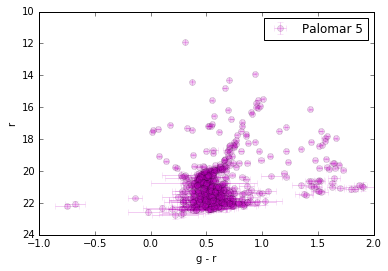

In [5]:
color = stars['g']-stars['r']
color_err = np.sqrt((stars['g_err']**2) + (stars['r_err']**2))


#plt.scatter(color,stars['r'], alpha=0.1)

#fig, ax = plt.subplots()
#ax.errorbar(x, y, xerr=0.2, yerr=0.4)
#plt.show()
#plt.figure(figsize=(9,6))
plt.errorbar(color, stars['r'].values, yerr = color_err, xerr=stars['r_err'].values, fmt='mo', alpha=0.2, label=cluster_name)

plt.axis([-1,2,24,10])
plt.legend(numpoints=1)
plt.xlabel('g - r')
plt.ylabel('r')
plt.show()

## Making sense of your plot

A successful color-magnitude diagram can take many shapes. How many of the following characteristic features of an H-R diagram can you locate?
    - Main Sequence
    - H-core exhaustion (MS turn-off point)
    - Red Giant Branch
    - Horizontal Branch
    - Asymptotic Giant Branch
    
Your cluster may look very different from a typical H-R diagram, especially since the SDSS telescope is limited in its range from about 14th to 24th magnitude. This means that you’re looking at a horizontal cross-section of the full cluster, so don’t be discouraged if all of its features aren’t visible.

Try re-plotting your H-R Diagram with any identifiable features labeled. The following links demonstrate how to add text annotations and arrow to your plot:
- http://matplotlib.org/users/text_intro.html
- http://matplotlib.org/examples/pylab_examples/arrow_simple_demo.html

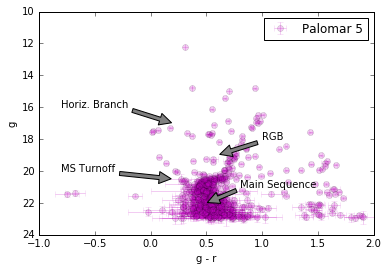

In [6]:
color = stars['g']-stars['r']
color_err = stars['g_err']+stars['r_err']

#plt.scatter(color,stars['r'], alpha=0.1)
plt.errorbar(color, stars['g'], yerr = color_err, xerr=stars['r_err'], fmt='mo', alpha=0.2, label=cluster_name)
plt.axis([-1,2,24,10])
plt.legend(numpoints=1)
plt.xlabel('g - r')
plt.ylabel('g')
plt.annotate('RGB', xy=(0.6, 19), xytext=(1.0, 18),
            arrowprops=dict(facecolor='gray', shrink=0.05))
plt.annotate('Main Sequence', xy=(0.5, 22), xytext=(0.8, 21),
            arrowprops=dict(facecolor='gray', shrink=0.03))
plt.annotate('Horiz. Branch', xy=(0.2, 17), xytext=(-0.8, 16),
            arrowprops=dict(facecolor='gray', shrink=0.03))
plt.annotate('MS Turnoff', xy=(0.2, 20.5), xytext=(-0.8, 20),
            arrowprops=dict(facecolor='gray', shrink=0.03))
plt.show() 

## Modeling stellar evolution tracks with isochrones

An isochrone is a computational model of stellar evolution. Parameters for a cluster like its age and chemical composition are plugged into a formula, and a computer simulates the development of stars within that cluster based upon their mass. The output is similar to the results of your SQL query from the first section of this Expedition: it’s a table of numbers, where each row lists the properties of a given star. That means you can also plot this data just like you did to produce your color-magnitude diagram, and it should look like an HR diagram for a cluster of the properties you selected.

Isochrones are designed to model the internal mechanisms of stars, so we use them to test our understanding of stellar evolution by comparing their results against external (measurable) properties. This is why we don’t plot them on the mass-luminosity axes or using other relationships: we can most easily measure stars’ luminosity and temperature, which makes Hertzsprung-Russell diagrams the most efficient format to place theory alongside observation. We’ll be doing things backwards, though, since we assume that isochrones are more or less correct and use them to learn more about your cluster.

When producing an isochrone to match your cluster, the primary variables you need to work with are the metallicity and age. These are two parameters that every isochrone generator should require, although they may offer additional options as well. To simplify the process, feel free to do an online search for your cluster’s metallicity. The result should be a value for Z or [Fe/H], and depending on which one your generator uses, you may need to convert these values. The equation for this is [Fe/H] = log(Z/0.02), using a base-10 logarithm. As for the age, you’ll be finding that for your cluster in the next section of the activity. For now, plug in 200 million (2•10⁸) years; this should offer a relatively long main sequence to compare against.

A brief online search can bring up several results for isochrone generators, typically hosted on university web domains, so feel free to explore your options before choosing which one to use. We will use the [Dartmouth Isochrone and Luminosity Function Generator 2012](http://stellar.dartmouth.edu/models/index.html). It’s important to note, however, that models of stellar evolution are constantly being developed as we deepen our knowledge of the processes involved and our computing power improves. The generators linked to above may soon obsolesce, so you may want to research if other options have been released recently.

Using the Dartmouth Generator, create an isochrome model with a combination of the following choices: 
- [Fe/H] options: [-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, +0.2, +0.3, +0.5]
- [alpha/H] options: [-0.2, 0.0, +0.2, +0.4, +0.6, +0.8]

If you have chosen a globular cluster, note that their very old stellar populations mean that the stars have extremely low metallicities (as they formed when the universe was young and metal-poor). 

Make sure you also select SDSS filters for your output!

Produce an isochrome using the Dartmouth web generator, and upload the *.iso file to your SciServer dashboard.



In [9]:
## Provide the name of your isochrome model file below:

isofile = "isochrones/tmp1487212885.iso"  # [Fe/H]=-2.0
#isofile = "tmp1487281984.iso" # [Fe/H]=0.2
print('Isochrone file loaded: '+isofile)

Isochrone file loaded: isochrones/tmp1487212885.iso


In [11]:
## Prepared for you below is a function that will 
## read in the models from your uploaded isochrome file.
def read_isofile(filename):

    # Set a minimum and maximum age range (in Gyrs) below:
    minage = 11.0
    maxage = 12.0
    sdss_u = []
    sdss_g = []
    sdss_r = []
    sdss_i = []
    sdss_z = []

    age = [] # in Gigayears
    mass = [] # ratio of stellar mass to M_sun
    logT = [] # log of the effective Temperature (K)
    logL = [] # log of the ratio of stellar luminosity to L_sun
    counter=0
    for line in open(filename).readlines():
        counter+=1
        cols = line.split()
        if (line.startswith('#')):
    #        print(counter, ': starts with hashtag: ',cols)
            if (counter >= 8):   # real data starts on line #8
                if ("AGE" in cols[0]):
                    block = (line[0:11])
                    thisage = float(block.split('=')[1])
    #                print("Reading stellar models with age: {0:.2f} Gyr".format(thisage))            
        else:
            if (thisage > minage) and (thisage < maxage):
#                print(cols)
                if (len(cols) > 0):
                    age.append(thisage)
                    mass.append(float(cols[1]))
                    logT.append(float(cols[2]))
                    logL.append(float(cols[4]))
                    sdss_u.append(float(cols[5]))
                    sdss_g.append(float(cols[6]))
                    sdss_r.append(float(cols[7]))
                    sdss_i.append(float(cols[8]))
                    sdss_z.append(float(cols[9]))
    return (sdss_u, sdss_g, sdss_r, sdss_i, sdss_z, age, mass, logT, logL)    

(sdss_u, sdss_g, sdss_r, sdss_i, sdss_z, age, mass, logT, logL) = read_isofile(isofile)

print("Read in {0:.0f} stellar models, ranging in age from {1:.2f} to {2:.2f} Gyr.".format(len(sdss_u), age[0], age[-1]))

Read in 267 stellar models, ranging in age from 11.50 to 11.50 Gyr.


## Now let's overplot the model on the H-R diagram

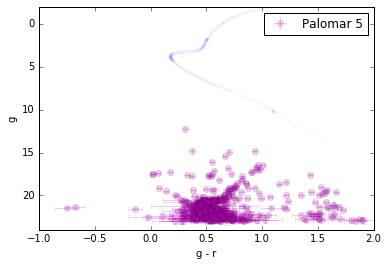

In [12]:
model_color = np.array(sdss_g)-np.array(sdss_r)
model_g = np.array(sdss_g)


#plt.scatter(color,stars['r'], alpha=0.1)
plt.errorbar(color, stars['g'], yerr = color_err, xerr=stars['r_err'], fmt='mo', alpha=0.2, label='Palomar 5')
plt.axis([-1,2,24,-2])
plt.legend(numpoints=1)
plt.xlabel('g - r')
plt.ylabel('g')
plt.plot(model_color,model_g, 'b.', alpha=0.02)
plt.show()


## Distance, extinction and reddening

That probably looks like an awfully bad fit. That is because our data are in apparent, reddened magnitudes and the isochrones provide absolute, unreddened magnitudes.

Now might be a good time to go back and ensure that you are selecting de-reddened ("dered") magnitudes in your SDSS star cluster query.  If you weren't, re-run your query and the steps that followed.

With that done, we'll also now try using our model to calculate the distance to the cluster.  To do this, we want to apply the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus), which relates apparent and absolute magnitudes with distance. 

Try guessing a distance to your cluster, in units of parsecs, and compute the distance modulus, using the calculation below. Then correct your model magnitudes using the distance modulus equation.  By guessing and overplotting a number of times, you will hopefully find the position where the model and data overlap.  Such agreement indicates that you have approximately found the distance to the cluster!

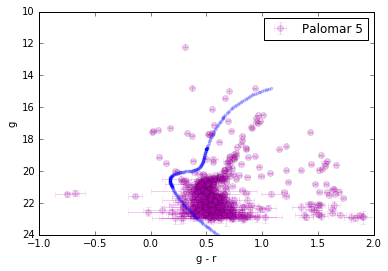

In [13]:
from math import log10
#distance = 23000.0 # approximate distance to Palomar 5 in units of parsecs

dm = 5*log10(cluster_distance/10)

model_g_corr = model_g+dm

plt.errorbar(color, stars['g'], yerr = color_err, xerr=stars['r_err'], fmt='mo', alpha=0.2, label='Palomar 5')
plt.axis([-1,2,24,10])
plt.legend(numpoints=1)
plt.xlabel('g - r')
plt.ylabel('g')
plt.plot(model_color,model_g_corr, 'b.', alpha=0.2)
plt.show()

## Now let's plot again, to check whether our model and data are in agreement for the distance to the cluster

If the isochrone is sitting to the left of the data, this may be due to interstellar dust extinction, which both absorbs light and reddens colours. The relationship between reddening  E(B−V) and extinction  AV  is:

AV=3.2*E(B−V)

(e.g., For NGC 7789, E(B−V) is roughly 0.2)

Try shifting your model to correct for the extinction, if necessary.

In [14]:

ebv = 0.1
av = 3.2*ebv

model_g_dered = np.array(model_g_corr) + av
model_gr_dered = np.array(model_color) + ebv
print('Done')

Done


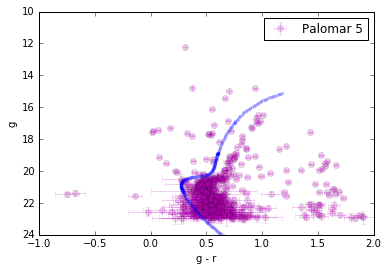

In [15]:
#plt.figure(figsize=(12,8))
plt.errorbar(color, stars['g'], yerr = color_err, xerr=stars['r_err'], fmt='mo', alpha=0.2, label='Palomar 5')
plt.axis([-1,2,24,10])
plt.legend(numpoints=1)
plt.xlabel('g - r')
plt.ylabel('g')
plt.plot(model_gr_dered,model_g_dered, 'b.', alpha=0.2)
plt.show()

## Determining the age of the cluster

Any additional offset between your model and the data is likely due to the cluster age.  Try going back to the earlier step where you created your model, and change the age range that's plotted.  With some experimentation, can you fit the age of the cluster, simultaneously with its distance and reddening?  

In [16]:
## Create a query to fetch stars for one of the following globular clusters
# Pal 3: RA = 151.3801, Dec = +0.072
# Pal 5: RA = 229.0128, Dec = -0.1082 

# Enter the coordinates of your star cluster (to be used to construct the query)
cluster_name = 'Palomar 5'
cluster_ra = 229.0128  # RA of the center of the cluster (in decimal degrees)
cluster_dec = -0.182   # Dec of the center of the cluster (in decimal degrees)
cluster_radius = 4.0   # Radius of the cluster, in arcminutes
cluster_distance = 23000 # approximate distance to your cluster, in units of parsecs

query_psf = 'SELECT p.objid, p.psfMag_u AS u, p.psfMagErr_u as u_err, p.psfMag_g AS g, p.psfMagErr_g as g_err, '
query_psf += 'p.psfMag_r AS r, p.psfMagErr_r as r_err, p.psfMag_i AS i, p.psfMagErr_i as i_err, '
query_psf += 'p.psfMag_z AS z, p.psfMagErr_z as z_err '
query_psf += 'FROM photoObj p '
query_psf += 'JOIN dbo.fGetNearbyObjEq(' + str(cluster_ra) + ', ' + str(cluster_dec) + ', ' + str(cluster_radius) + ') n '
query_psf += 'ON p.objid = n.objID '
query_psf += 'WHERE p.type = 6 '
query_psf += 'AND p.psfMag_g BETWEEN -10 AND 23 '
query_psf += 'AND p.psfMag_u/p.psfMagerr_u > 30 '
query_psf += 'AND p.psfMag_g/p.psfMagerr_g > 30 '
query_psf += 'AND p.psfMag_r/p.psfMagerr_r > 30 '
query_psf += 'AND p.psfMag_i/p.psfMagerr_i > 30 '
query_psf += 'AND p.psfMag_z/p.psfMagerr_z > 30'
#print(query)   # useful for debugging, remove first # to uncomment

# send query to CasJobs
stars_psf = CasJobs.executeQuery(query_psf, "dr14")

stars_psf

,objid,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err
0,1237648721252188544,23.10421,0.299779,22.01362,0.063172,21.56408,0.066792,20.76682,0.103958,21.23878,0.291216
1,1237648721252188545,23.17597,0.363830,21.73647,0.063623,21.33640,0.070581,21.38207,0.100430,21.11552,0.256301
2,1237648721252188402,20.95989,0.063972,19.77056,0.025416,19.18340,0.021199,18.95025,0.021882,18.83147,0.045118
3,1237648721252188411,22.38535,0.181122,21.73760,0.053783,21.40717,0.064437,21.41290,0.101640,21.68291,0.465597
4,1237648721252188404,21.86954,0.116361,20.51904,0.023511,20.11138,0.023396,20.00243,0.028822,19.94234,0.095213
5,1237648721252188399,18.21918,0.010977,16.84235,0.013478,16.28653,0.012485,16.05206,0.011994,15.93242,0.021170
6,1237648721252189913,22.39229,0.165922,21.42901,0.073556,21.04012,0.061846,20.95379,0.076070,21.29265,0.330972
7,1237648721252189912,21.55843,0.089667,20.54294,0.024449,20.05939,0.022862,19.92058,0.026037,19.80416,0.083998
8,1237648721252189021,24.40671,0.665712,22.15380,0.080186,21.89000,0.101436,21.51956,0.102174,22.55620,0.603224
9,1237648721252189916,21.48352,0.081616,20.64957,0.024927,20.48446,0.035453,20.46732,0.057268,20.59792,0.173668


In [17]:
## Create a query to fetch stars for one of the following globular clusters
# Pal 3: RA = 151.3801, Dec = +0.072
# Pal 5: RA = 229.0128, Dec = -0.1082 

# Enter the coordinates of your star cluster (to be used to construct the query)
cluster_name = 'Palomar 5'
cluster_ra = 229.0128  # RA of the center of the cluster (in decimal degrees)
cluster_dec = -0.182   # Dec of the center of the cluster (in decimal degrees)
cluster_radius = 4.0   # Radius of the cluster, in arcminutes
cluster_distance = 23000 # approximate distance to your cluster, in units of parsecs

query_dered = 'SELECT p.objid, p.dered_u AS u, p.modelMagErr_u as u_err, p.dered_g AS g, p.modelMagErr_g as g_err, '
query_dered += 'p.dered_r AS r, p.modelMagErr_r as r_err, p.dered_i AS i, p.modelMagErr_i as i_err, '
query_dered += 'p.dered_z AS z, p.modelMagErr_z as z_err '
query_dered += 'FROM photoObj p '
query_dered += 'JOIN dbo.fGetNearbyObjEq(' + str(cluster_ra) + ', ' + str(cluster_dec) + ', ' + str(cluster_radius) + ') n '
query_dered += 'ON p.objid = n.objID '
query_dered += 'WHERE p.type = 6 '
query_dered += 'AND p.dered_g BETWEEN -10 AND 23 '
query_dered += 'AND p.dered_u/p.modelMagErr_u > 30 '
query_dered += 'AND p.dered_g/p.modelMagErr_g > 30 '
query_dered += 'AND p.dered_r/p.modelMagErr_r > 30 '
query_dered += 'AND p.dered_i/p.modelMagErr_i > 30 '
query_dered += 'AND p.dered_z/p.modelMagErr_z > 30 '
#print(query)   # useful for debugging, remove first # to uncomment

# send query to CasJobs
stars_dered = CasJobs.executeQuery(query_dered, "dr14")

stars_dered

,objid,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err
0,1237648721252190003,21.66285,0.128981,20.81986,0.029862,20.62018,0.034656,20.47397,0.042571,20.58141,0.175898
1,1237648721252190005,23.62903,0.582229,21.86510,0.068842,21.49794,0.073586,21.45626,0.101242,22.43637,0.635978
2,1237648721252190004,22.52527,0.277981,21.39326,0.048595,20.98188,0.049157,20.85921,0.062465,20.62933,0.196257
3,1237648721252190815,23.23472,0.448657,22.36456,0.102655,21.76284,0.092020,21.56653,0.111463,22.03602,0.544985
4,1237648721252190028,22.92758,0.352553,21.56276,0.052170,21.21326,0.055726,21.09906,0.071771,21.18667,0.292021
5,1237648721252189994,23.69375,0.579382,21.98735,0.073412,21.67861,0.082688,21.86944,0.140499,21.17753,0.290702
6,1237648721252190025,22.69376,0.298215,21.55013,0.053105,21.13523,0.053762,21.00523,0.068483,21.15333,0.293612
7,1237648721252190818,25.18612,0.543105,22.67546,0.133053,22.14602,0.126913,22.00245,0.161732,21.16957,0.295243
8,1237648721252190029,22.08191,0.181048,22.10613,0.081792,21.89796,0.100993,21.66128,0.118580,21.45052,0.363769
9,1237648721252190754,23.72254,0.587206,22.57836,0.120381,22.21845,0.131639,21.58016,0.109177,21.87804,0.478277


Done


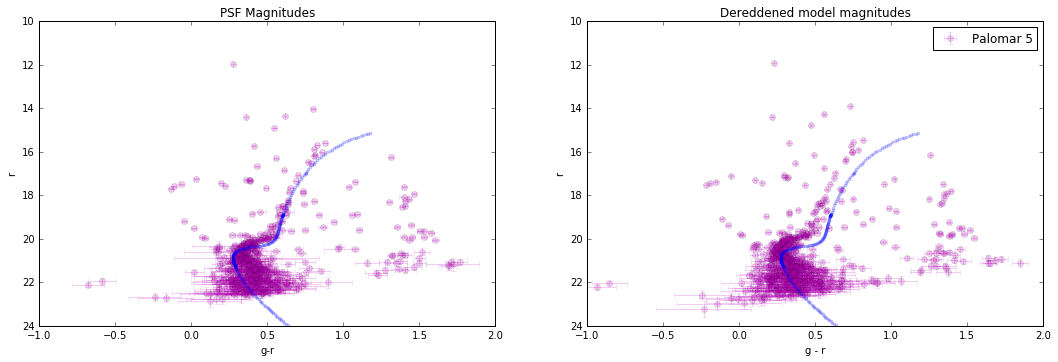

In [18]:
color_psf = stars_psf['g']-stars_psf['r']
color_err_psf = np.sqrt((stars_psf['g_err']**2) + (stars_psf['r_err']**2))

color_dered = stars_dered['g']-stars_dered['r']
color_err_dered = np.sqrt((stars_dered['g_err']**2) + (stars_dered['r_err']**2))



ebv = 0.1
av = 3.2*ebv

model_g_dered = np.array(model_g_corr) + av
model_gr_dered = np.array(model_color) + ebv
print('Done')




fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

#plt.scatter(color,stars['r'], alpha=0.1)

#fig, ax = plt.subplots()
#ax.errorbar(x, y, xerr=0.2, yerr=0.4)
#plt.show()
#plt.figure(figsize=(9,6))

ax1.errorbar(color_psf, stars_psf['r'].values, yerr = color_err_psf, xerr=stars_psf['r_err'].values, fmt='mo', alpha=0.2, label=cluster_name)
ax2.errorbar(color_dered, stars_dered['r'].values, yerr = color_err_dered, xerr=stars_dered['r_err'].values, fmt='mo', alpha=0.2, label=cluster_name)


ax1.axis([-1,2,24,10])

ax2.axis([-1,2,24,10])

#ax1.plot(model_color,model_g_corr, 'b.', alpha=0.2)
ax1.plot(model_gr_dered,model_g_dered, 'b.', alpha=0.2)
ax2.plot(model_gr_dered,model_g_dered, 'b.', alpha=0.2)

ax1.set_title('PSF Magnitudes')
ax1.set_xlabel('g-r')
ax1.set_ylabel('r')

ax2.set_title('Dereddened model magnitudes')
ax2.set_xlabel('g-r')
ax2.set_ylabel('r')

plt.xlabel('g - r')
plt.ylabel('r')
plt.legend(numpoints=1)


plt.show() 